In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
from omegaconf import OmegaConf
from torchsummary import summary

from modules.autoencoders import HamiltonianAutoencoder
from modules.preprocessing import BRATSDataModule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = OmegaConf.load('./config.yaml')

hvae = HamiltonianAutoencoder(**cfg.autoencoder).to(device)

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [2]:
hvae.on_train_start()

In [17]:
x = torch.randn(4, 2, 128, 128).to(device, dtype=torch.float32)
pos = torch.randint(0, 64, (4,)).to(device, dtype=torch.long)
y = torch.randint(0, 2, size=(4,)).to(device, dtype=torch.long)
y = torch.nn.functional.one_hot(y, num_classes=2).to(device, dtype=torch.float32)

o = hvae(x, pos, y)

In [20]:
br = BRATSDataModule(**cfg.data)
br.prepare_data()
br.setup()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([12800, 2, 128, 128])
Test shape: torch.Size([0, 2, 128, 128])
Train slice positions shape: torch.Size([12800])
Test slice positions shape: torch.Size([0])
Train has mask shape: torch.Size([12800, 2])
Test has mask shape: torch.Size([0, 2])
Min: 0.0, Max: 1.0


In [21]:
batch = next(iter(br.train_dataloader()))
print(batch[0].shape, batch[0][:, 0, ...].max(), batch[0][:, 0, ...].min())
print(torch.unique(batch[0][:, 1, ...]))

print(batch[1].shape, batch[1].max(), batch[1].min())
print(torch.unique(batch[2]))

torch.Size([32, 2, 128, 128]) tensor(0.9762, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
torch.Size([32]) tensor(61) tensor(1)
tensor([0., 1.])


In [4]:
hvae.positional_encoder.embedding.device

device(type='cuda', index=0)

In [3]:
hvae = hvae.to(device)
hvae.sample_img()

tensor([[[[0.5018, 0.4930, 0.5086,  ..., 0.4966, 0.4953, 0.4952],
          [0.4996, 0.4980, 0.5218,  ..., 0.5182, 0.5019, 0.4901],
          [0.5095, 0.4963, 0.5071,  ..., 0.4771, 0.4925, 0.4830],
          ...,
          [0.4895, 0.5203, 0.5200,  ..., 0.5108, 0.5101, 0.5065],
          [0.5028, 0.5048, 0.5127,  ..., 0.5141, 0.4970, 0.5121],
          [0.5007, 0.5089, 0.5127,  ..., 0.5045, 0.5128, 0.4885]],

         [[0.5091, 0.5033, 0.5147,  ..., 0.5157, 0.5079, 0.5119],
          [0.5033, 0.5210, 0.5112,  ..., 0.5104, 0.5072, 0.4937],
          [0.5077, 0.4876, 0.5043,  ..., 0.5161, 0.5070, 0.5200],
          ...,
          [0.4992, 0.5152, 0.5092,  ..., 0.4907, 0.5204, 0.5031],
          [0.5123, 0.4856, 0.5177,  ..., 0.5077, 0.5169, 0.5041],
          [0.5086, 0.5042, 0.4993,  ..., 0.5193, 0.5004, 0.5039]]]],
       device='cuda:0')

In [25]:
import torch

data = dataset[0]  # Your dataset of shape N, 2, 128, 128
mask = data[:, 1, :, :]
nonzero_mask = torch.sum(mask, dim=(1, 2)) > 0
has_mask = nonzero_mask.int()

print(has_mask)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


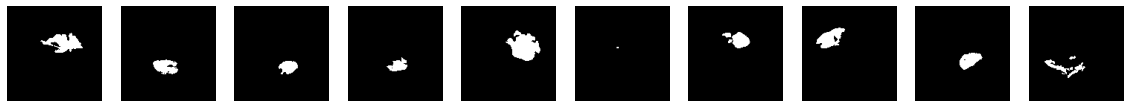

In [37]:
import matplotlib.pyplot as plt

rand_empty = np.random.choice(np.where(has_mask == 1)[0], size=(10,))

plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(data[rand_empty[i], 1, ...], cmap='gray')
    plt.axis('off')

plt.show()

In [2]:
x = torch.randn(4, 1, 128, 128).to(device)
pos = torch.randint(0, 64, size=(4,)).to(device, dtype=torch.long)

recon_x, z, z0, rho, eps0, gamma, mu, log_var = hvae(x, pos)

In [11]:
data = np.load('./data/brats_preprocessed.npy')

In [12]:
# norm between 0 and 1
data = (data - data.min()) / (data.max() - data.min())

In [14]:
data.max()

1.0

In [2]:
from modules.preprocessing import BRATSDataModule


datamodule = BRATSDataModule(**cfg.data)
datamodule.prepare_data()
datamodule.setup()
loader = datamodule.train_dataloader()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([10880, 2, 128, 128])
Test shape: torch.Size([1920, 2, 128, 128])
Train slice positions shape: torch.Size([10880])
Test slice positions shape: torch.Size([1920])
Min: 0.0, Max: 1.0


In [10]:
g = hvae.sample_img(n_samples=1)

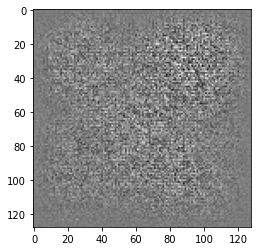

In [16]:
import matplotlib.pyplot as plt

plt.imshow((g[0, 0, ...].detach().cpu().numpy() * 255).astype(np.uint8), cmap='gray')

In [20]:
hvae.eval()
generated = hvae.sample_img(n_samples=5)

# channel wise grid
img_grid = torch.cat([ 
    torch.hstack([img for img in generated[:, idx, ...]])
    for idx in range(generated.shape[1])
], dim=0)

img_grid = img_grid.unsqueeze(-1).detach().cpu().numpy()
img_grid = (img_grid * 255).astype(np.uint8) # denormalize

print(img_grid.shape)

(256, 640, 1)


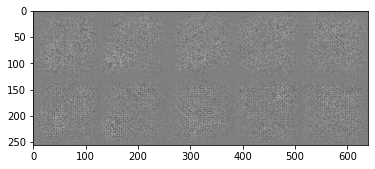

In [19]:
plt.imshow(img_grid, cmap='gray')

In [1]:
from modules.autoencoders import HamiltonianAutoencoder

hvae = HamiltonianAutoencoder.load_from_checkpoint('./ckpt-epoch=9.ckpt')

/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.3, which is newer than your current Lightning version: v2.0.2
  rank_zero_warn(


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hvae = hvae.to(device)
hvae.positional_encoder.embedding = hvae.positional_encoder.embedding.to(device)
g = hvae.sample_img(n_samples=1, pos=torch.tensor([20]).to(device))

# import numpy as np
# import matplotlib.pyplot as plt
# plt.imshow((g[0, 0, ...].detach().cpu().numpy() * 255).astype(np.uint8), cmap='gray')

In [16]:
from modules.preprocessing import BRATSDataModule

br = BRATSDataModule(**cfg.data)

tensor(0.0767, device='cuda:0')

In [25]:
br.prepare_data()
br.setup()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([10880, 2, 128, 128])
Test shape: torch.Size([1920, 2, 128, 128])
Train slice positions shape: torch.Size([10880])
Test slice positions shape: torch.Size([1920])
Min: 0.0, Max: 1.0
